In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from glob import glob
from ast import literal_eval
from os import path
from copy import deepcopy

In [3]:
! ls -ltr ~/des/PearceMCMC/*.hdf5

-rw-r--r-- 1 swmclau2 des  86636396 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_xi_gg_rmin_0.5_HOD_v3.hdf5
-rw-r--r-- 1 swmclau2 des 107081669 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/HOD_xi_gg_rmin_0.5_HOD_v3.hdf5
-rw-r--r-- 1 swmclau2 des 206936544 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_xi_gg_rmin_1.0_HOD_v3.hdf5
-rw-r--r-- 1 swmclau2 des 165334619 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/HOD_xi_gg_rmin_1.0_HOD_v3.hdf5
-rw-r--r-- 1 swmclau2 des 125424714 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_xi_gg_rmin_None_HOD_v3.hdf5
-rw-r--r-- 1 swmclau2 des  65943539 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_xi_gg_rmin_None_CorrAB_v3.hdf5
-rw-r--r-- 1 swmclau2 des  87633168 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_xi_gg_rmin_0.5_CorrAB_v3.hdf5
-rw-r--r-- 1 swmclau2 des 100690059 Jun 13  2019 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_xi_gg_rmin_1.0_CorrAB_v3.hdf5
-rw-r--r-- 1 swmclau2 des  93985164 Jun 13  2019 /u/ki/swmclau2/des/Pearc

In [4]:
#fname = '/scratch/users/swmclau2/PearceMCMC/500_walkers_10000_steps_chain_cosmo_zheng_xi_lowmsat.npy'
fnames = sorted(glob('/u/ki/swmclau2/des/PearceMCMC/HOD_ds_h_rmin_0.5_HOD.hdf5'))

Assume all chains run with same true values, only thing that differs is the rmin. 

In [5]:
fnames

['/u/ki/swmclau2/des/PearceMCMC/HOD_ds_h_rmin_0.5_HOD.hdf5']

In [6]:
f = h5py.File(fnames[0], 'r')

In [7]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [8]:
n_walkers = f.attrs['nwalkers']

In [9]:
chain_pnames = f.attrs['param_names']

In [10]:
sim_info = literal_eval(f.attrs['sim'])

In [11]:
gal_type = literal_eval(f.attrs['sim'])['gal_type']

In [12]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [13]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'ln10As': r'$\ln(10A_s)$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$' }

In [14]:
hod_param_names = []
cosmo_param_names = []
cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff'])
for pname in chain_pnames:
    if pname in cosmo_names:
        cosmo_param_names.append(param_name_dict[pname])
    else:
        hod_param_names.append(param_name_dict[pname])
        
param_names = deepcopy(cosmo_param_names)
param_names.extend(hod_param_names)

In [15]:
f.close()

In [16]:
c = ChainConsumer()

In [17]:
n_burn = 1000

for fname in fnames:
#for fname in [fnames[0], fnames[3]]:

    f = h5py.File(fname, 'r')
    chain = f['chain'][n_burn*n_walkers:]
    chain = chain[np.all(chain!=0.0, axis = 1), :]
    
    name = path.basename(fname).split('_')[4]
    if name == "None":
        name = "0.0"
    
    print chain.shape, chain.shape[0]/n_walkers
    c.add_chain(chain, parameters=param_names, name = name)

(4900000, 12) 49000


In [18]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [19]:
hod_idxs = np.array(range(len(cosmo_param_names), len(cosmo_param_names)+len(hod_param_names)-1)) #skip eta
cosmo_idxs = np.array(range(len(cosmo_param_names)))

In [20]:
cosmo_param_names

['$\\Omega_b h^2$',
 '$\\Omega_c h^2$',
 '$w_0$',
 '$n_s$',
 '$\\ln(10A_s)$',
 '$H_0$',
 '$N_{eff}$']

In [21]:
chain.shape

(4900000, 12)

In [22]:
hod_param_names

['$\\log(M_1)$',
 '$\\log(M_0)$',
 '$\\sigma_{\\log M }$',
 '$\\alpha$',
 '$\\eta$']

In [23]:
if chain.shape[1] == 7:
    cosmo_chain = chain
    
elif chain.shape[1] == 5:
    hod_chain = chain
else:
    hod_chain = chain[:,hod_idxs]
    cosmo_chain = chain[:,cosmo_idxs]

In [24]:
if gal_type == 'HOD':
    from pearce.mocks import cat_dict
    cosmo_params = {'simname': sim_info['simname'], 'boxno': sim_info['sim_hps']['boxno'],\
                    'realization': sim_info['sim_hps']['realization'], 'scale_factors':[sim_info['scale_factor']],\
                    'system': 'ki-ls'}
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    
    cpv = cat._get_cosmo_param_names_vals()

    cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}
    cosmo_true_vals = [cat_val_dict[pn] for pn in chain_pnames if pn in cat_val_dict]
    
    hod_params = sim_info['hod_params']
    hod_true_vals = [hod_params[key] for key in chain_pnames if key in hod_params]
    #hod_true_vals.insert(0, 0)
    #hod_true_vals.insert(3, 0)
    hod_true_vals.append(1.0)
    #hod_true_vals = [MAP[idx] for idx, key in enumerate(chain_pnames) if key in hod_params]
else: #SHAM
    #cosmo_true_vals = [3.7,70.7317,-1.13151,0.12283, 3.11395,  0.953515,  0.021762]
    #cosmo_true_vals = [0.046*0.7**2, (0.27-0.046)*0.7**2, -1, 0.95, 3.08511, 70, 3.04] 
    # multidark
    cosmo_true_vals = np.array([0.02214, 0.1175, -1, 0.9676, 3.0819, 0.6881*100, 3.04]) #darksky
    hod_true_vals = np.array([np.inf for p in hod_param_names])

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


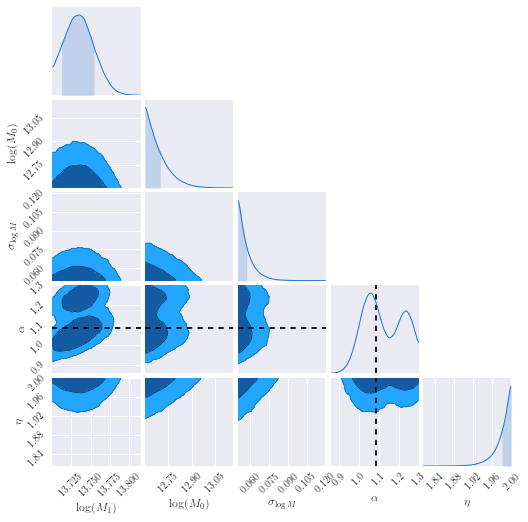

In [25]:
fig = c.plotter.plot(figsize='GROW', parameters = hod_param_names, truth=hod_true_vals) 
#plt.suptitle('HSAB')
fig.show()

In [26]:
cosmo_true_vals

[0.022762900000000003, 0.11283, -0.861513, 0.971515, 3.06395, 65.7317, 3.2]

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


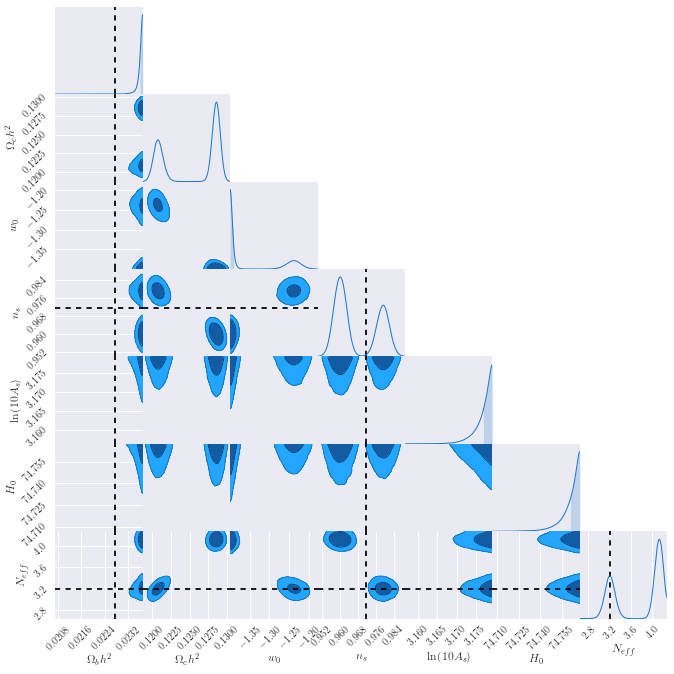

In [27]:
fig = c.plotter.plot(figsize='PAGE', parameters = cosmo_param_names, truth=cosmo_true_vals) 
fig.show()

In [28]:
from copy import deepcopy
true_vals  = deepcopy(cosmo_true_vals)
true_vals.extend(hod_true_vals)

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


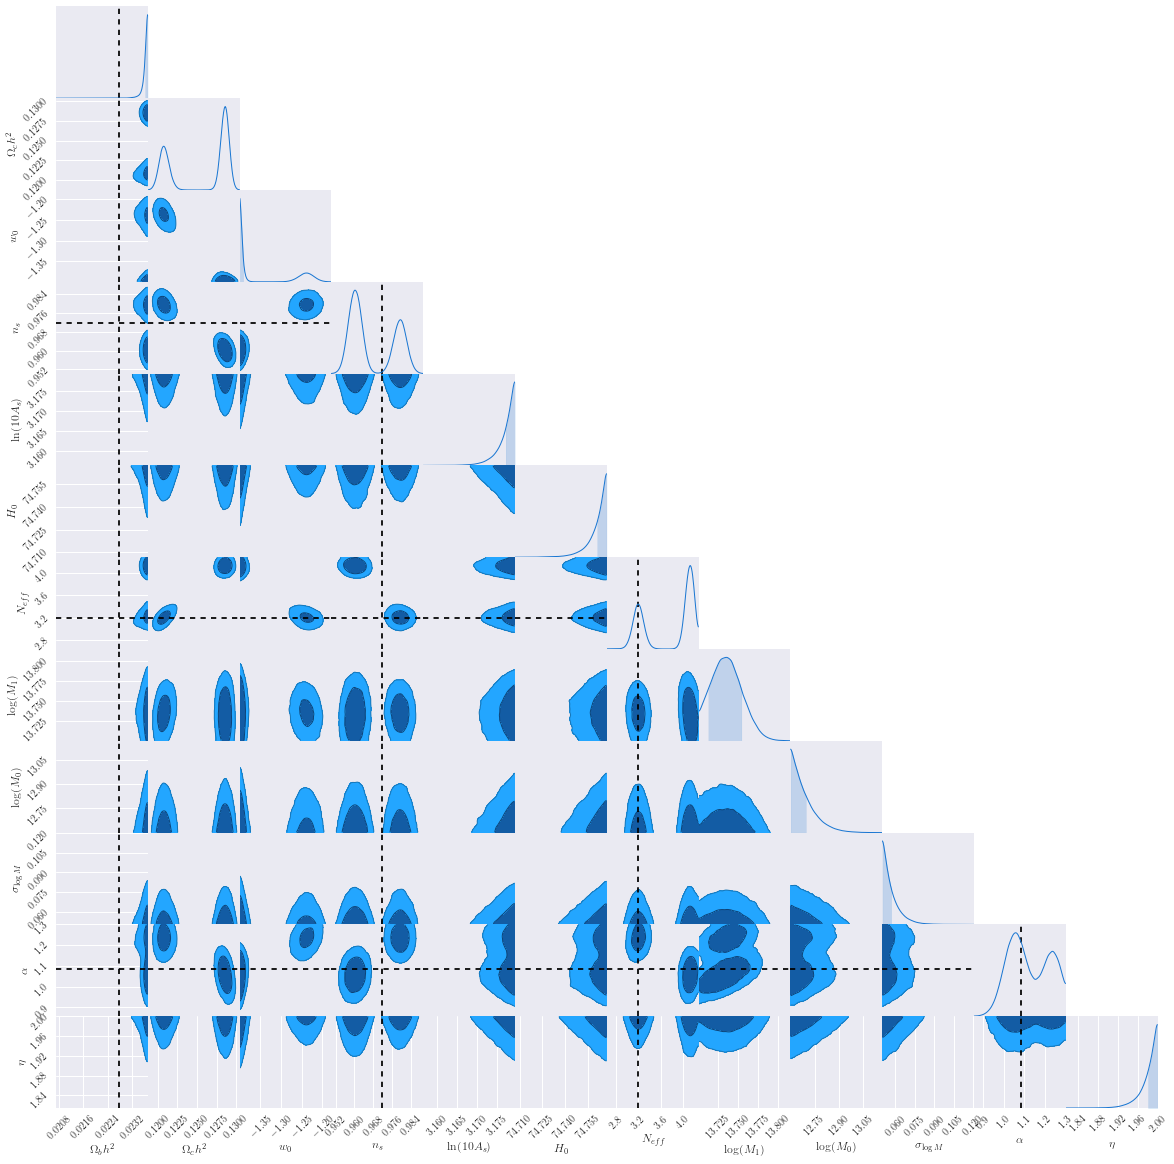

In [29]:
fig = c.plotter.plot(figsize='GROW', parameters = param_names, truth=true_vals) 
fig.show()

In [30]:
idxs = [1,2]

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


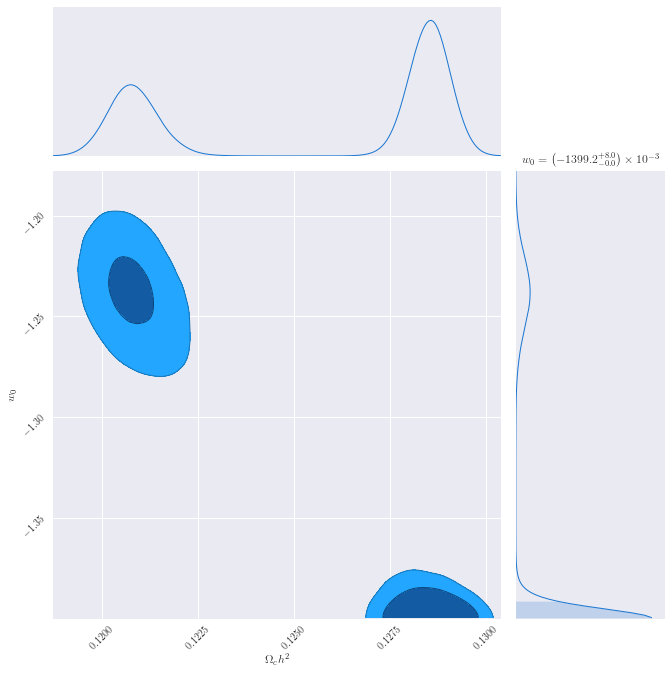

In [31]:
fig = c.plotter.plot(figsize='PAGE', parameters = [cosmo_param_names[i] for i in idxs]\
                                    , truth=[cosmo_true_vals[i] for i in idxs]) 
fig.show()

In [32]:
f.close()

In [33]:
cosmo_true_vals

[0.022762900000000003, 0.11283, -0.861513, 0.971515, 3.06395, 65.7317, 3.2]